In [1]:
import at3d
import numpy as np
import os
import sys
import xarray as xr
from collections import OrderedDict
import pylab as py
path = '/Users/khargenr/AT3D/at3d'

In [2]:
#load the cloud.
cloud_scatterer = at3d.util.load_from_csv(os.path.join(path, './data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt'),
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset(os.path.join(path, './data/ancillary/AFGL_summer_mid_lat.nc'))
#subset the atmosphere
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 10.0]})
#merge the atmosphere and cloud z coordinates
#merged_z_coordinate = at3d.grid.combine_z_coordinates([aerosol_scatterer, cloud_scatterer])

#make a merged grid for the rte.
rte_grid = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           cloud_scatterer.z)

In [3]:

# rte_grid = at3d.grid.make_grid(0.1, 10, 0.1, 10, merged_z_coordinate)
#resample the cloud onto the rte_grid
cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#define any necessary variables for microphysics here.
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


# Reconstruction MODIS + MISR

In [4]:
#define sensors.
sensor_resolution = 0.02
sensors_dict = at3d.containers.SensorsDict()
sensor_zenith_list =  [75.0,60.0,45.6,26.1]*2 + [0.0]
sensor_azimuth_list = [90]*4 + [-90]*4 +[0.0]
for zenith,azimuth in zip(sensor_zenith_list, sensor_azimuth_list):
    sensors_dict.add_sensor('MISR',
                    at3d.sensor.orthographic_projection(0.865, 
                                                           rte_grid, 
                                                           sensor_resolution, 
                                                           sensor_resolution,
                                                           azimuth, zenith,
                                                           altitude='TOA', stokes=['I'])
                           )

for wavelength in [1.64, 2.13]:
    sensors_dict.add_sensor('MODIS',
    at3d.sensor.orthographic_projection(wavelength, 
                                           rte_grid, 
                                           sensor_resolution, 
                                           sensor_resolution,
                                           azimuth, zenith,
                                           altitude='TOA', stokes=['I'])
                         )
wavelengths = sensors_dict.get_unique_solvers()
min_stokes = sensors_dict.get_minimum_stokes()

In [5]:
#rayleigh optical properties if desired.
rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths, atmosphere, rte_grid)

In [6]:
solvers = at3d.containers.SolversDict()
cloud_poly_tables = OrderedDict()

for wavelength in wavelengths:
    mie_mono_table = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
    # print(wavelength)
    # #optical properties from mie calculations.
    # # Cloud
    # water_file = './mie_tables/mie_table_water_SWIR_%d.nc'%(wavelength*1e3)
    # try:
    #     mie_mono_table = xr.load_dataset(water_file)
    # except IOError:
    #     mie_mono_table = at3d.mie.get_mono_table(
    #         'Water', 
    #         (wavelength, wavelength),
    #         minimum_effective_radius=0.1,
    #     )
    #     mie_mono_table.to_netcdf(water_file, mode='w')
    cloud_size_distribution = at3d.size_distribution.get_size_distribution_grid(
        mie_mono_table.radius.data,
        size_distribution_function=at3d.size_distribution.gamma,
        particle_density=1.0,
        reff={'coord_min':.1,'coord_max':30.0,'npoints':30,'spacing':'linear','units':'micron'},
        veff={'coord_min':0.09,'coord_max':0.11,'npoints':2,'spacing':'linear','units':'unitless'},
    )
    poly_table = at3d.mie.get_poly_table(cloud_size_distribution, mie_mono_table)
    cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
    cloud_poly_tables[wavelength] = poly_table

    # Define solvers
    config = at3d.configuration.get_config()
    config['num_mu_bins'] = 8
    config['num_phi_bins'] = 16
    config['split_accuracy'] = 0.03
    config['spherical_harmonics_accuracy'] = 0 #.001
    config['solution_accuracy'] = 1e-4
    solvers.add_solver(
        wavelength, 
        at3d.solver.RTE(
            numerical_params=config,
            medium={
                'cloud': cloud_optical_scatterer,
                'rayleigh': rayleigh_scatterer_list[wavelength]
            },
            source=at3d.source.solar(wavelength, np.cos(np.deg2rad(60.0)), 0.0, solarflux=1.0),
            surface=at3d.surface.ocean_unpolarized(10.0, 0.0, delx=10.0, dely=10.0),
            num_stokes=min_stokes[wavelength],
            name=None
        )
    )

In [7]:
# get total OD
for wvl in wavelengths:
    sensor_od = sensors_dict['MISR']['sensor_list'][-1]
    solvers[wvl].optical_path(sensor_od)
    print('cloud OD @ %.3f nm ='%wvl, sensor_od.optical_path.data.mean())
    # get Rayleigh OD

cloud OD @ 0.865 nm = 3.321035
cloud OD @ 1.640 nm = 3.3963447
cloud OD @ 2.130 nm = 3.4415367


In [8]:
#very important for the retrieval. the unknowns are visible extinction
#and reff not LWC and Reff. Much more orthogonal.
scaling_factor = cloud_poly_tables[0.865].extinction[:].copy(deep=True).data
#print(scaling_factor)
for wavelength in cloud_poly_tables:
    cloud_poly_tables[wavelength]['extinction'][:] /= scaling_factor

In [9]:
sensors_dict.get_measurements(solvers, n_jobs=8)

Sensordict = sensors_dict
uncertainty = at3d.uncertainties.NullUncertainty('L2', 6.2e9)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
Sensordict.add_uncertainty_model('MISR', uncertainty)
Sensordict.add_uncertainty_model('MODIS', uncertainty)
# uncertainty = at3d.uncertainties.RadiometricNoiseUncertainty(0, .001)
# Sensordict.add_uncertainty_model('MISR', uncertainty)
# Sensordict.add_noise('MISR')
# Sensordict.add_uncertainty_model('MODIS', uncertainty)
# Sensordict.add_noise('MODIS')
forward_sensors = Sensordict.make_forward_sensors() # make a perfect copy of the sensor with the same subpixel rays.

scale_reff = 1.5e2
#scale_aerosol_density = 1e4

wavelengths = forward_sensors.get_unique_solvers()

mask = solvers[0.865].medium['cloud'].extinction.data > 0.0


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.865 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.607  0.324E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     1  -0.555  0.272E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     1  -0.653  0.358E+00    30784    16.04  0.251   [Radiance 0.865 micron]
     2  -1.110  0.370E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     2  -1.311  0.399E+00    30784    16.04  0.251   [Radiance 0.865 micron]
     2  -1.012  0.321E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     3  -1.482  0.393E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     3  -1.638  0.415E+00    30784    16.04  0.251   [Radiance 0.865 micron]
     3  -1.431  0.349E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     4  -1.671  0.293E+00    30817    16.10  0.252   [Radiance 2.130 micron]
     4  

In [10]:
ext_profile = np.sum(solvers[0.865].medium['cloud'].extinction.data, axis=(0,1))
CBH = rte_grid.z.data[np.where(ext_profile>0)[0][0]]
CTH = rte_grid.z.data[np.where(ext_profile>0)[0][-1]]
print(CBH, CTH)

0.56 1.4


In [11]:
initial_cloud = xr.Dataset(
    data_vars={
        'density':(['x','y','z'], np.ones((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))),
        'reff': (['x','y','z'], np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+10.0),
        'veff':(['x','y','z'] ,np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+0.1)
    },
    coords=rte_grid.coords
)

#resample the cloud onto the rte_grid
initial_cloud_on_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer_on_rte_grid.copy(deep=True))
reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))

def state_to_grid_density_cloud(state):
    state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
    state_on_grid[mask] = state[1:]
    return state_on_grid

def state_to_grid_reff_cloud(state):
    state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
    state_on_grid[:,:,:] = state[0]*(rte_grid.z.data-0.44)**(1.0/3)/scale_reff #+state[1]/scale3
    state_on_grid[np.where(state_on_grid < 4.1)] = 4.1
    state_on_grid[np.where(np.isnan(state_on_grid))] = 4.1
    return state_on_grid

solvers_reconstruct = at3d.containers.SolversDict()
rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

def set_state_fn(state):

    #update microphysics
    #aerosol_scatterer_on_rte_grid = initial_aerosol_on_grid.copy(deep=True)
    cloud_scatterer_on_rte_grid = initial_cloud_on_grid.copy(deep=True)

    cloud_scatterer_on_rte_grid['density'][:] = state_to_grid_density_cloud(state)
    cloud_scatterer_on_rte_grid['reff'][:] = state_to_grid_reff_cloud(state)
    #update optical properties
    for wavelength in wavelengths:
        poly_table = cloud_poly_tables[wavelength] #tables are used here.
        cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
        #cloud_optical_scatterer['extinction'][:] = state_to_grid_ext_cloud(state)
        
        #aerosol_poly_table = aerosol_poly_tables[wavelength]
        #aerosol_optical_scatterer = at3d.medium.table_to_grid(aerosol_scatterer_on_rte_grid, aerosol_poly_table)
        #aerosol_optical_scatterer['extinction'][:] = state_to_grid_ext_aerosol(state)      

#         config = at3d.configuration.get_config('./default_config.json')
#         config['num_mu_bins'] = 2
#         config['num_phi_bins'] = 4
#         config['split_accuracy'] = 0.1
#         config['spherical_harmonics_accuracy'] = 0.001
#         config['solution_accuracy'] = 1e-5
        solvers_reconstruct.add_solver(wavelength, at3d.solver.RTE(#numerical_params=config,
                                numerical_params=solvers[wavelength].numerical_params,#config,
                                                medium={'cloud': cloud_optical_scatterer,
                                                       'rayleigh': rayleigh_scatterer_list[wavelength]
                                                       },
                                                source=solvers[wavelength].source,
                                                surface=solvers[wavelength].surface,
                                                num_stokes=solvers[wavelength]._nstokes,
                                                name=None
                                                )
                                )

# unknown_scatterers = at3d.containers.UnknownScatterers()
# unknown_scatterers.add_unknown('cloud', ['density','reff'], cloud_poly_tables)
# unknown_scatterers.create_derivative_tables()

mie_mono_tables = OrderedDict()
for wavelength in wavelengths:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, cloud_optical_scatterer
)

# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(grid_to_optical_properties,
        reff=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridProfile(mask=mask)),
        density=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridMask(mask=mask)),
    
    #reff=(at3d.transforms.CoordinateTransform(), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
    )
)

def project_gradient_to_state(state, gradient):
    cloud_gradient = gradient.gradient.sel(variable_name='density',
                                        scatterer_name='cloud').data[mask]

    reff_gradient = gradient.gradient.sel(variable_name='reff',
                                           scatterer_name='cloud').where(mask, np.nan)
    
    reff_gradient1 = np.nansum(reff_gradient, axis=(0,1))*(rte_grid.z.data - 0.44)**(1.0/3)
    #reff_gradient2 = np.nansum(reff_gradient,axis=(0,1))

    full_grad = np.append(np.nansum(reff_gradient1)/scale_reff, cloud_gradient)
    
    #print some things here because I'm lazy.
    print('reff', state[0]/scale_reff , full_grad[0])
    print('cloud density avg.', np.mean(state[1:]), np.mean(full_grad[1:]))
    print('reff profile retrieve', state_to_grid_reff_cloud(state).mean(axis=(0,1)))
    print('reff profile true', reff_profile_true)
    return full_grad

min_bound = np.zeros(1+np.sum(mask))+1e-5
min_bound[0] = 1e-4*scale_reff

max_bound = np.zeros(1+np.sum(mask))+200
max_bound[0] = 30.0*scale_reff

obj_fun = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    Sensordict, 
    solvers_reconstruct,
    forward_sensors,
    unknown_scatterers,
    set_state_fn,
    project_gradient_to_state,
    #exact_single_scatter=False,
    parallel_solve_kwargs={'n_jobs': 4, 'mpi_comm':None,
                                  'verbose':False, 'maxiter':100, 'init_solution':True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':False},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bound,
    max_bounds=max_bound
)

# initial guess
x0_reff = 10
x0_ext_cloud = 10
x0 = np.append(np.array([x0_reff*scale_reff]), x0_ext_cloud*np.ones(np.sum(mask)))
print(x0)
print(state_to_grid_reff_cloud(x0).mean(axis=(0,1)))

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_31217/3900719876.py:12: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[1500.   10.   10. ...   10.   10.   10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]


In [12]:
optimizer = at3d.optimize.Optimizer

In [13]:
optimizer = at3d.optimize.Optimizer

In [14]:
optimizer.options

In [15]:
%%time
#define optimizer (no prior function)
optimizer = at3d.optimize.Optimizer(obj_fun)#, prior_fn=prior_func)
optimizer._options['maxls'] = 8
optimizer._options['maxiter'] = 400 #maxiter to 1 to debug the saving of result.
#optimize for the specified initial condition.
result = optimizer.minimize(x0)

reff 10.0 232.11628063637414
cloud density avg. 10.0 -26.00050401158106
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3944     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62261D+06    |proj g|=  2.32116D+02


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.064162254333496'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 8.45255812909084 -248.74903858439237
cloud density avg. 36.00711911172 5.411835174788792
reff profile retrieve [4.1        4.1        4.1        4.16916018 4.58875454 4.94308598
 5.25281268 5.52977563 5.78146844 6.01296948 6.22789808 6.42893535
 6.61812926 6.79708364 6.96708071 7.12916363 7.28419378 7.43289168
 7.57586682 7.71363995 7.84665989 7.97531652 8.09995097 8.22086359
 8.33832037 8.45255813]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    1    f=  1.77204D+06    |proj g|=  2.48749D+02


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.0903751850128174'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 9.712744823524856 -99.71621438709141
cloud density avg. 33.23759491316879 0.27265550994555654
reff profile retrieve [4.1        4.1        4.18509488 4.79073771 5.27288913 5.68004763
 6.03595129 6.35420647 6.64342401 6.90943941 7.15641157 7.38742137
 7.60482208 7.81045666 8.00579849 8.19204625 8.37018975 8.54105693
 8.70534815 8.86366179 9.01651358 9.16435156 9.30756768 9.44650709
 9.58147542 9.71274482]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    2    f=  1.11568D+06    |proj g|=  9.97162D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.0440192222595215'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 10.60136501412689 371843527.4058303
cloud density avg. 31.607527916064427 -15613688.488598641
reff profile retrieve [ 4.1         4.1         4.56798971  5.22904288  5.75530639  6.19971587
  6.5881812   6.93555359  7.25123167  7.54158485  7.81115253  8.06329743
  8.30058817  8.52503628  8.73824996  8.94153755  9.13597942  9.32247925
  9.5018015   9.67459927  9.84143549 10.00279918 10.15911817 10.31076916
 10.45808576 10.60136501]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.0903751850128174'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 9.712746711200138 8642876955.115997
cloud density avg. 33.237591450455234 -266544078.96482086
reff profile retrieve [4.1        4.1        4.18509569 4.79073864 5.27289016 5.68004873
 6.03595246 6.35420771 6.6434253  6.90944075 7.15641296 7.3874228
 7.60482356 7.81045818 8.00580005 8.19204785 8.37019138 8.54105859
 8.70534984 8.86366351 9.01651534 9.16435334 9.30756949 9.44650892
 9.58147729 9.71274671]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.0851948261260986'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 10.157055862663514 -70.62851420665304
cloud density avg. 32.42255968325983 -0.2297862194616149
reff profile retrieve [ 4.1         4.1         4.3765427   5.00989076  5.51409827  5.9398823
  6.31206683  6.64488065  6.94732849  7.2255128   7.48378275  7.72536012
  7.95270587  8.16774723  8.372025    8.5667927   8.7530854   8.93176892
  9.10357567  9.26913139  9.42897541  9.58357626  9.73334383  9.87863904
 10.01978152 10.15705586]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    3    f=  9.39030D+05    |proj g|=  7.06285D+01


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0078248977661133'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 11.125184193120209 -37.66099146778793
cloud density avg. 30.935444711375048 -1.1252016609012754
reff profile retrieve [ 4.1         4.1         4.79369655  5.48741272  6.03967919  6.50604718
  6.91370679  7.27824304  7.60951895  7.91421863  8.1971058   8.46170932
  8.71072472  8.94626293  9.17001161  9.38334376  9.5873931   9.78310799
  9.97129065 10.15262645 10.32770614 10.4970429  10.66108569 10.82022984
 10.97482543 11.12518419]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    4    f=  6.76326D+05    |proj g|=  1.95764D+02
reff 11.314094359908747 283932875.6609176
cloud density avg. 30.901295529549525 -17346978.32117544
reff profile retrieve [ 4.1         4.1         4.87509548  5.58059122  6.14223541  6.61652252
  7.03110435  7.40183058  7.73873169  8.0486053   8.336296    8.6053926
  8.85863638  9.09817413  9

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0078248977661133'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 11.12518442686502 286053666.6414709
cloud density avg. 30.935444669121132 -8461236.45491997
reff profile retrieve [ 4.1         4.1         4.79369665  5.48741283  6.03967932  6.50604732
  6.91370694  7.27824319  7.60951911  7.9142188   8.19710597  8.4617095
  8.7107249   8.94626312  9.17001181  9.38334395  9.5873933   9.7831082
  9.97129086 10.15262667 10.32770636 10.49704312 10.66108592 10.82023006
 10.97482567 11.12518443]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 11.219639393386883 480498519.1606595
cloud density avg. 30.918370099335327 -36004203.04024265
reff profile retrieve [ 4.1         4.1         4.83439606  5.53400203  6.09095736  6.56128492
  6.97240565  7.34003689  7.6741254   7.98141205  8.26670099  8.53355105
  8.78468064  9.02221862  9.24786698  9.46301036  9.66879213  9.86616868
 10.05594905 10.23882


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 11.634272285000234 -27.85110405225738
cloud density avg. 29.882821017996342 -1.2436234084958402
reff profile retrieve [ 4.1         4.1         5.01305596  5.73851656  6.31605473  6.80376371
  7.23007781  7.61129522  7.95773031  8.27637304  8.57220511  8.84891688
  9.10932722  9.35564365  9.58963107  9.81272528 10.02611192 10.23078272
 10.42757661 10.61721033 10.80030167 10.97738726 11.14893665 11.31536323
 11.47703311 11.63427229]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    6    f=  5.34392D+05    |proj g|=  1.53211D+02
reff 11.63306336369131 765299537.3309649
cloud density avg. 30.09006897450012 -43168481.904517494
reff profile retrieve [ 4.1         4.1         5.01253505  5.73792027  6.31539843  6.80305673
  7.22932653  7.61050433  7.95690342  8.27551304  8.57131437  8.84799739
  9.10838067  9.3546715   9

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '44'. Max cell optical depth: '2.302086114883423'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '142'. Max cell optical depth: '2.744114398956299'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -513.952714821263
cloud density avg. 34.71210259487987 nan
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 11.63306336369131 -31.93402359687579
cloud density avg. 30.09006897450012 -0.08650045315135788
reff profile retrieve [ 4.1         4.1         5.01253505  5.73792027  6.31539843  6.80305673
  7.22932653  7.61050433  7.95690342  8.27551304  8.57131437  8.84799739
  9.10838067  9.3546715   9.58863461  9.81170564 10.0250701  10.22971964
 10.42649308 10.6161071  10.7991794  10.9762466  11.14777816 11.31418744
 11.47584053 11.63306336]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.

In [16]:
#at3d.util.save_forward_model("inso_aerosol_forward_model.nc", sensors_dict, solvers)
#at3d.util.save_forward_model("inso_aerosol_reconstruction.nc", Sensordict, solvers_reconstruct)

Text(0.5, 1.0, 'Corr. coeff. 0.918')

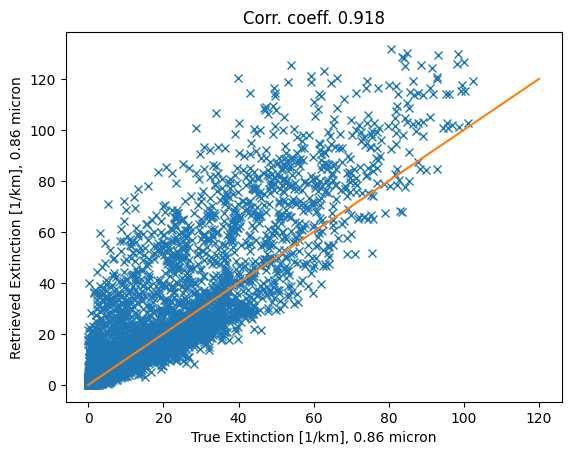

In [17]:
#compare cell averaged extinction on the TRUE grid.
true_geo_extinct = list(solvers.values())[0].medium['cloud']
true_geo_extinct.extinction.data = 3.0*solvers[0.865].medium['cloud'].density.data/(2.0*997.0* solvers[0.865].medium['cloud'].reff.data*1e-6)

reference, other = at3d.util.cell_average_comparison(
     true_geo_extinct,
                                   list(solvers_reconstruct.values())[0].medium['cloud'],
                                  'extinction')
py.figure()
py.plot(reference.ravel(),
        other.ravel(),'x')
py.plot([0, 120.0], [0.0, 120.0])
py.xlabel('True Extinction [1/km], 0.86 micron')
py.ylabel('Retrieved Extinction [1/km], 0.86 micron')
py.title('Corr. coeff. %.3f'%np.corrcoef(reference.ravel(), other.ravel())[1, 0])

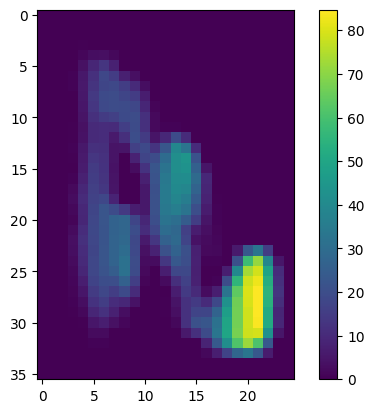

In [18]:
py.figure()
py.imshow(other[12])
py.colorbar()

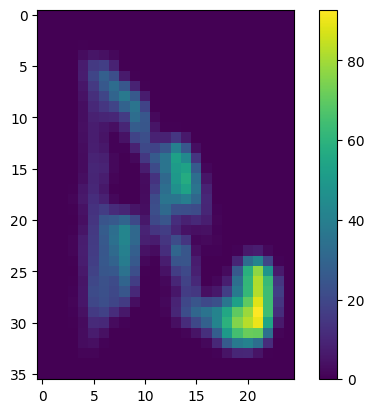

In [19]:
py.figure()
py.imshow(reference[12])
py.colorbar()

(0.0, 22.0)

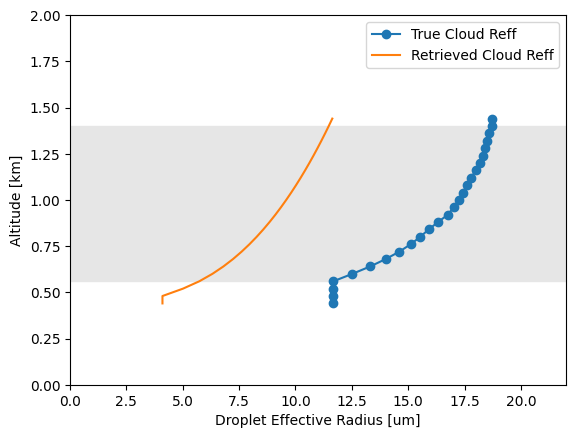

In [20]:
#plot Reff profiles.

#remake the true grid since it was overwritten.
rte_grid2 = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           cloud_scatterer.z)

py.figure()
py.plot(solvers[0.865].medium['cloud'].reff[16,16], rte_grid.z, marker='o', label = 'True Cloud Reff')
py.plot(solvers_reconstruct[0.865].medium['cloud'].reff[16,16], rte_grid2.z, label='Retrieved Cloud Reff')
py.legend()
py.xlabel('Droplet Effective Radius [um]')
py.ylabel('Altitude [km]')
py.fill_between([0,23], CBH, CTH, color='0.9')
py.ylim(0, 2.)
py.xlim(0, 22)

(0.0, 2.0)

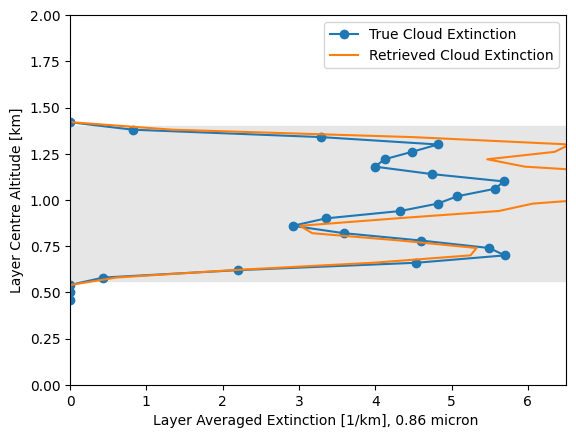

In [21]:
z = 0.5*(rte_grid.z.data[1:] + rte_grid.z.data[:-1])
py.figure()
py.plot(reference.mean(axis=(0,1)), z, marker='o',
       label='True Cloud Extinction')
py.plot(other.mean(axis=(0,1)), z, 
        label='Retrieved Cloud Extinction')
#solvers[0.86].medium['cloud'].extinction.where(mask, np.nan).mean(axis=(0,1)).plot()
py.legend()
py.fill_between([0,6.5], CBH, CTH, color='0.9')
py.xlabel('Layer Averaged Extinction [1/km], 0.86 micron ')
py.ylabel('Layer Centre Altitude [km]')
py.xlim(0, 6.5)
py.ylim(0,2)

In [22]:
cameras = ['DF', 'CF', 'BF', 'AF', 'AN', 'AA', 'BA', 'CA', 'DA']
fig, ax = plt.subplots(2, len(cameras), figsize=(15,3), dpi=200)
for i, (true_im, rec_im) in enumerate(zip(forward_sensors.get_images('MISR'), sensors_dict.get_images('MISR'))):
    #py.figure()
    #image.I.plot(vmax=0.2,vmin=0.0)
    vza = np.mean(np.arccos(true_im.mu.data)/np.pi*180)
    ax[0,i].set_title(f"{cameras[i]}\n{vza:.1f} deg")
    im=ax[1,i].pcolormesh(true_im.x, true_im.y, rec_im.I.data * np.pi, vmin=0, vmax=0.5, shading='auto')
    im1=ax[0,i].pcolormesh(true_im.x, true_im.y, true_im.I.data * np.pi, vmin=0, vmax=0.5, shading='auto')
    ax[0,i].set_xticks([])
    ax[1,i].set_xlabel('x [km]')
cbar1 = plt.colorbar(im1, ax=ax[1,i])
cbar2 = plt.colorbar(im, ax=ax[0,i])
cbar1.set_label('BRF')
cbar2.set_label('BRF')
ax[1,0].set_ylabel('$\mathbf{Estimated}$\ny [km]')
ax[0,0].set_ylabel('$\mathbf{True}$\ny [km]')
plt.tight_layout();
print(np.mean(np.arccos(true_im.mu.data)/np.pi*180))

NameError: name 'plt' is not defined

In [ ]:
import pylab as py
#%matplotlib qt
for image in forward_sensors.get_images('MODIS'):
    py.figure()
    image.I.plot(vmax=0.2,vmin=0.0)

In [ ]:
import pylab as py
#%matplotlib qt
for image1, image2 in zip(sensors_dict.get_images('MISR'),forward_sensors.get_images('MISR')):
    py.figure()
    (image1.I - image2.I).plot(vmax=0.05,vmin=-0.05, cmap='seismic')

In [ ]:
import pylab as py
#%matplotlib qt
for image1, image2 in zip(sensors_dict.get_images('MODIS'),forward_sensors.get_images('MODIS')):
    py.figure()
    (image1.I - image2.I).plot(vmax=0.05,vmin=-0.05, cmap='seismic')

In [ ]:
aero = aerosol_poly_tables[0.86]

In [ ]:
aerosol_mono_table.radius

In [ ]:
radii = np.linspace(0.005, 20, 10000)
n = at3d.size_distribution.lognormal(radii,10,veff=0.1,alpha=None,particle_density=1.0)

In [ ]:
py.figure()
#py.plot(radii, at3d.size_distribution.lognormal(radii,0.2,veff=0.01,alpha=None,particle_density=1.0))
py.plot(radii, at3d.size_distribution.lognormal(radii,6,veff=np.log(2.51),particle_density=1.0))
#py.plot(radii, at3d.size_distribution.lognormal(radii,12,alpha=np.log(2.51),particle_density=1.0))
#py.plot(radii, at3d.size_distribution.lognormal(radii,10,veff=0.2,alpha=None,particle_density=2.0))
py.xscale('log')
py.yscale('log')

In [ ]:
np.log10(2.51)

In [ ]:
n[-500:]

In [ ]:
alpha = np.log(2.51)
distr_width_aerosol = np.exp(alpha**2) - 1
print(alpha, distr_width_aerosol)